# Cluster PC examples

This notebook supports Chapter 4.3.1 Examples of C-PC in https://sharelatex.tum.de/read/npjkjggtqffh . It shows how to use the clustercausal package to construct a DAG, data and a corresponding C-DAG and then run the PC and C-PC algorithm to compare their outputs. 

In [58]:
#importing libraries and dependencies
%load_ext autoreload
%autoreload 2
import numpy as np
from causallearn.search.ConstraintBased.PC import pc
from clustercausal.experiments.Simulator import Simulator
from clustercausal.experiments.Evaluator import Evaluator
from clustercausal.algorithms.ClusterPC import ClusterPC as ClusterPC
from clustercausal.clusterdag.ClusterDAG import ClusterDAG
from clustercausal.utils.Utils import *

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


### Example 1: 3-node chain with 2 clusters
This example shows how C-PC can orient additional edges for the graph $X_1 \rightarrow X_2 \rightarrow X_3$, with clusters $C_1 = \{X_1\}$ and $C_2 = \{X_2, X_3\}$.

In [49]:
# Construct DAG as CausalGraph object and get adjacency matrix with make_graph() function from Utils.py
node_names = ['X1', 'X2', 'X3']
parent_dict = {'X1': [], 'X2': ['X1'], 'X3': ['X2']}
cg, W = make_graph(node_names, parent_dict)

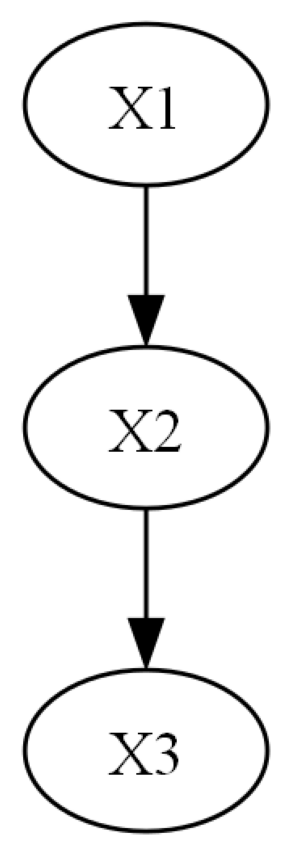

In [50]:
# Draw DAG
cg.draw_pydot_graph()

Next construct ClusterDAG object with C-DAG $C_1 \rightarrow C_2$

In [51]:
cluster_mapping = {'C1': ['X1'], 'C2': ['X2', 'X3']}
cluster_edges = [('C1', 'C2')]
cluster_dag = ClusterDAG(cluster_mapping=cluster_mapping, cluster_edges=cluster_edges)

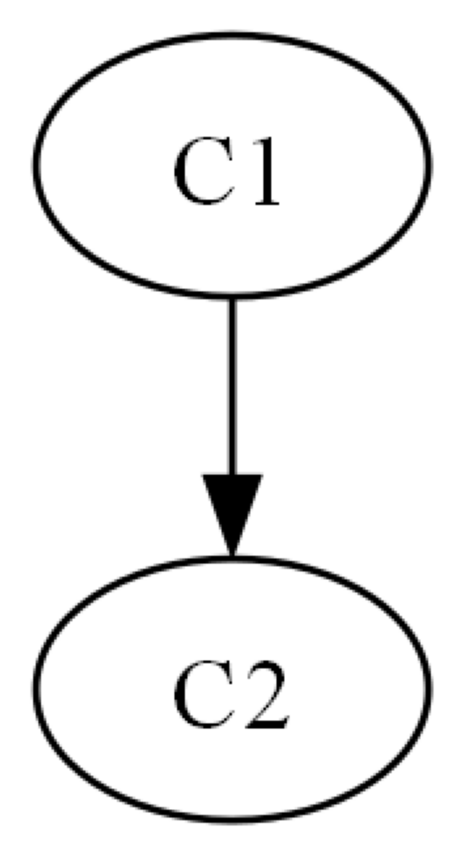

In [52]:
# Draw C-DAG
cluster_dag.cluster_graph.draw_pydot_graph()

Next the causal graph associated to the C-DAG has to be initalized, edges have to be pruned and oriented. cluster_dag.cdag_to_mpdag handles this and then cluster_dag.cg becomes available. This object is the supergraph of all DAGs compatible with the C-DAG

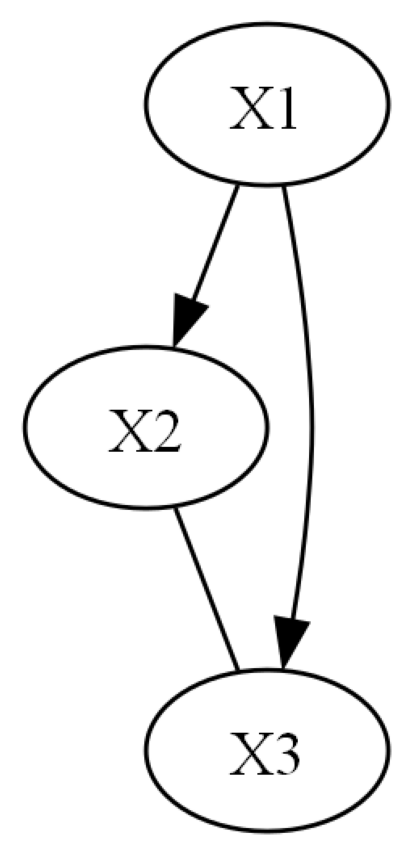

In [53]:
cluster_dag.cdag_to_mpdag()
cluster_dag.cg.draw_pydot_graph()

Lastly, the true dag is added to cluster_dag. 

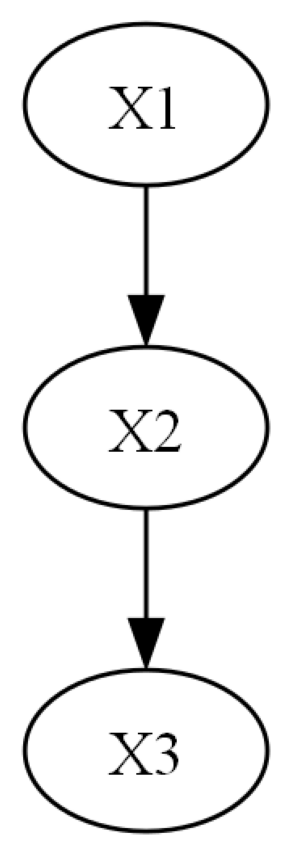

In [66]:
cluster_dag.true_dag = cg
cluster_dag.true_dag.draw_pydot_graph()

Next generate gaussian data for C-PC and PC with Utils.py gaussian_data(). This is an additive noise model with weights 1.0. 

In [54]:
data = gaussian_data(W = W, sample_size = 1000, seed = 42)
data.shape

(1000, 3)

To run PC use the causallearn package. 

In [61]:
pc_est_graph = pc(data, alpha = 0.1, verbose=False, node_names=node_names)

Depth=1, working on node 2: 100%|██████████| 3/3 [00:00<00:00, 749.96it/s] 


pc_est_graph is a CausalGraph object and can be drawn

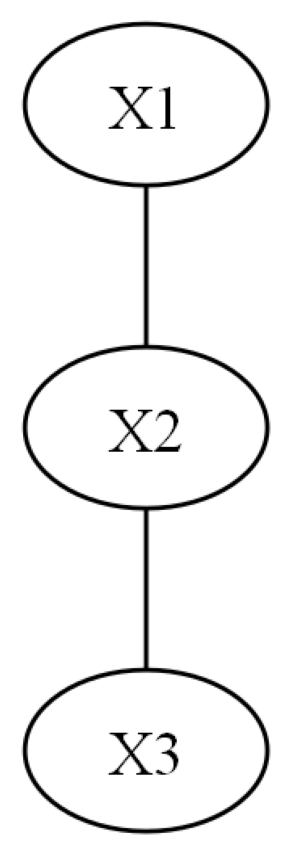

In [62]:
pc_est_graph.draw_pydot_graph()

To run C-PC initialize a cluster_pc object and use the cluster_pc.run() function. 

In [64]:
cluster_pc = ClusterPC(cdag = cluster_dag, data = data, alpha = 0.1, 
                  indep_test = "fisherz", \
                  verbose = False, show_progress=True)
cluster_pc_est_graph = cluster_pc.run()

C2 phase, Depth=1, working on node 2: 100%|██████████| 2/2 [00:00<?, ?it/s, duration: 0.01sec]

Duration of algorithm was 0.01sec


cluster_est_graph is a CausalGraph object and can be drawn. 

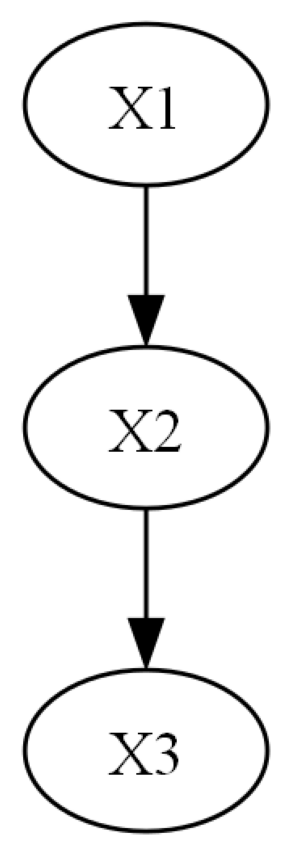

In [65]:
cluster_pc_est_graph.draw_pydot_graph()

Due to the edges from the cluster, C-PC can orient the edge $X_1 \rightarrow X_2$ and then due to orientation rules $X_2 \rightarrow X_3$.

For more evaluations one can call the Evaluator class from clustercausal. The error comes due to precision being nan as there are no true and false positives. SID can be calculated but takes around 5 seconds, can be turned off by changing to get_causallearn_metrics(sid = False). 

The adjacency confusion counts how many edges are correct. Arrow confusion counts how many arrows are correct. SHD is the structural hamming distance and SID is the structural intervention distance.

In [87]:
# Evaluator works on the GeneralGraph object of a CausalGraph object, which is cg.G, cluster_dag.true_dag.G or pc_est_graph.G
eval_pc = Evaluator(truth = cluster_dag.true_dag.G, est = pc_est_graph.G)
adjacency_confusion, arrow_confusion, shd, sid = eval_pc.get_causallearn_metrics(sid = True)
print("Adjacency confusion: ", adjacency_confusion)
print("Arrow confusion: ", arrow_confusion)
print("SHD: ", shd)
print("SID: ",  sid)

invalid value encountered in double_scalars
invalid value encountered in double_scalars


Adjacency confusion:  {'true_positive': 2, 'false_positive': 0, 'false_negative': 0, 'true_negative': 1, 'precision': 1.0, 'recall': 1.0, 'f1_score': 1.0}
Arrow confusion:  {'true_positive': 0.0, 'false_positive': 0.0, 'false_negative': 2.0, 'true_negative': 7.0, 'precision': nan, 'recall': 0.0, 'f1_score': nan, 'true_positive_ce': 0.0, 'false_positive_ce': 0.0, 'false_negative_ce': 2.0, 'true_negative_ce': 7.0, 'precision_ce': nan, 'recall_ce': 0.0, 'f1_score_ce': nan}
SHD:  0
SID:  {'sid_lower': 0, 'sid_upper': 6}


In [88]:
eval_cluster_pc = Evaluator(truth = cluster_dag.true_dag.G, est = cluster_pc_est_graph.G)
adjacency_confusion, arrow_confusion, shd, sid = eval_cluster_pc.get_causallearn_metrics(sid = True)
print("Adjacency confusion: ", adjacency_confusion)
print("Arrow confusion: ", arrow_confusion)
print("SHD: ", shd)
print("SID: ",  sid)

Adjacency confusion:  {'true_positive': 2, 'false_positive': 0, 'false_negative': 0, 'true_negative': 1, 'precision': 1.0, 'recall': 1.0, 'f1_score': 1.0}
Arrow confusion:  {'true_positive': 2.0, 'false_positive': 0.0, 'false_negative': 0.0, 'true_negative': 7.0, 'precision': 1.0, 'recall': 1.0, 'f1_score': 1.0, 'true_positive_ce': 2.0, 'false_positive_ce': 0.0, 'false_negative_ce': 0.0, 'true_negative_ce': 7.0, 'precision_ce': 1.0, 'recall_ce': 1.0, 'f1_score_ce': 1.0}
SHD:  0
SID:  {'sid_lower': 0, 'sid_upper': 0}


# Evaluation examples

In [37]:
%load_ext autoreload
%autoreload 2
%load_ext line_profiler
import numpy as np
from clustercausal.experiments.Simulator import Simulator
from clustercausal.experiments.Evaluator import Evaluator
from clustercausal.algorithms.ClusterPC import ClusterPC as ClusterPC
# from clustercausal.algorithms.ClusterPCv2 import ClusterPC as ClusterPCv2
from clustercausal.clusterdag.ClusterDAG import ClusterDAG
from clustercausal.utils.Utils import *

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [38]:
%autoreload 2
# Node names from 0 to 19
# node_names = ['0', '1', '2', '3', '4', '5', '6', '7', '8', '9']#, '10', '11', '12', '13', '14', '15', '16', '17', '18','19']
node_names = None
#seed = 12343
simulation = Simulator(n_nodes = 40, n_edges = 40, n_clusters = 4, seed = 122663, sample_size = 1000, node_names=node_names)
cluster_dag = simulation.run()

2023-11-10 12:00:21,731 - c:\Users\JanMarco\MLProjects\Masterthesis\masterthesis\mthesis\lib\site-packages\castle\datasets\simulator.py[line:270] - INFO: Finished synthetic dataset


In [39]:
print(cluster_dag.cluster_mapping)
print(cluster_dag.cluster_edges)

{'C1': ['X1', 'X32', 'X7', 'X36', 'X10', 'X12', 'X26', 'X31', 'X15', 'X17', 'X30', 'X39', 'X27', 'X28', 'X35', 'X3', 'X4', 'X5', 'X19', 'X23', 'X2'], 'C2': ['X6', 'X18', 'X22', 'X25', 'X34', 'X11', 'X14'], 'C3': ['X20', 'X21', 'X37', 'X38', 'X8', 'X29', 'X24', 'X16', 'X40', 'X13', 'X9'], 'C4': ['X33']}
[('C1', 'C2'), ('C1', 'C3'), ('C2', 'C3'), ('C2', 'C4'), ('C3', 'C4'), ('C1', 'C4')]


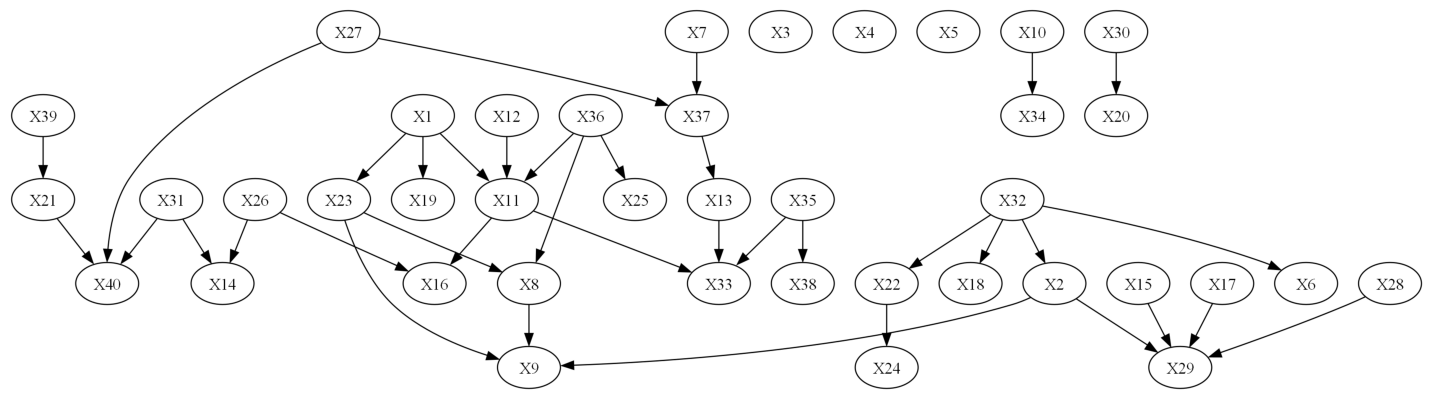

In [40]:
cluster_dag.true_dag.draw_pydot_graph()

In [41]:
# cluster_dag.cdag_to_mpdag()
# cluster_dag.draw_mpdag()

In [42]:
# c4 = ClusterDAG.get_node_by_name('C4', cluster_dag.cluster_graph)
# c4_local_graph = cluster_dag.get_local_graph(cluster = c4)
# c4_local_graph.draw_pydot_graph()

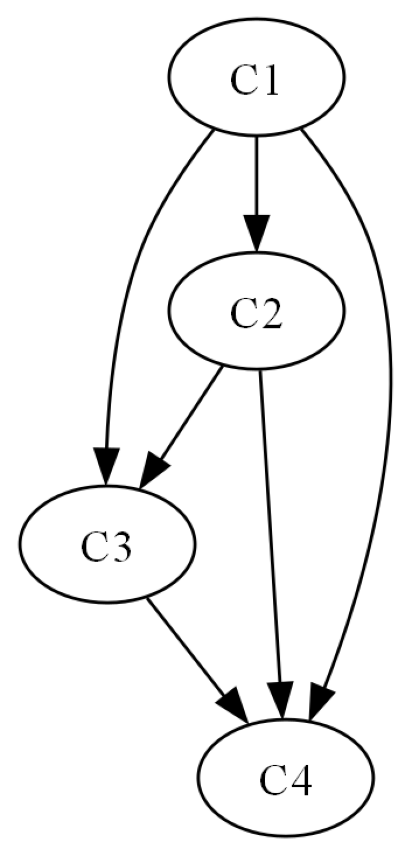

In [43]:
cluster_dag.draw_cluster_graph()

In [44]:
cluster_pcv1 = ClusterPCv1(cdag = cluster_dag, data = cluster_dag.data, alpha = 0.1, \
                  indep_test = "fisherz", \
                  verbose = False, show_progress=True)
%lprun -f cluster_pcv1.run -f cluster_pcv1.into_cluster_phase cluster_pcv1.run()

NameError: name 'ClusterPCv1' is not defined

In [ ]:
cluster_pcv1 = ClusterPCv1(cdag = cluster_dag, data = cluster_dag.data, alpha = 0.1, \
                  indep_test = "fisherz", \
                  verbose = False, show_progress=True)
est_graph_v1 = cluster_pcv1.run()

In:     C4, Depth=0, working on node 32: 100%|██████████| 1/1 [00:00<00:00, 28.60it/s, duration: 0.14sec]


Duration of algorithm was 1349.54sec


In [ ]:
%load_ext line_profiler
cluster_pcv2 = ClusterPCv2(cdag = cluster_dag, data = cluster_dag.data, alpha = 0.1, \
                  indep_test = "fisherz", \
                  verbose = False, show_progress=True)
%lprun -f cluster_pcv2.run -f cluster_pcv2.cluster_phase cluster_pcv2.run()

The line_profiler extension is already loaded. To reload it, use:
  %reload_ext line_profiler


C4 phase, Depth=5, working on node 32: 100%|██████████| 1/1 [00:00<00:00, 20.85it/s, duration: 0.52sec]


Duration of algorithm was 3.47sec


Timer unit: 1e-07 s

Total time: 3.46767 s
File: c:\Users\JanMarco\MLProjects\Masterthesis\masterthesis\clustercausal\algorithms\ClusterPCv2.py
Function: run at line 75

Line #      Hits         Time  Per Hit   % Time  Line Contents
    75                                               def run(self) -> CausalGraph:
    76         1         13.0     13.0      0.0          start = time.time()
    77         1         13.0     13.0      0.0          no_of_var = self.data.shape[1]
    78         1         12.0     12.0      0.0          assert len(self.cdag.node_names) == no_of_var
    79         1          5.0      5.0      0.0          if self.verbose:
    80                                                       print(
    81                                                           f"Topological ordering {(self.cdag.cdag_list_of_topological_sort)}"
    82                                                       )
    83         4         33.0      8.2      0.0          for cluster_name in s

In [ ]:
cluster_pcv2 = ClusterPCv2(cdag = cluster_dag, data = cluster_dag.data, alpha = 0.1, \
                  indep_test = "fisherz", \
                  verbose = False, show_progress=True, true_dag = cluster_dag.true_dag.nx_graph)
est_graph_v2= cluster_pcv2.run()

C4 phase, Depth=5, working on node 32: 100%|██████████| 1/1 [00:00<00:00, 26.33it/s, duration: 0.45sec]


Duration of algorithm was 2.89sec


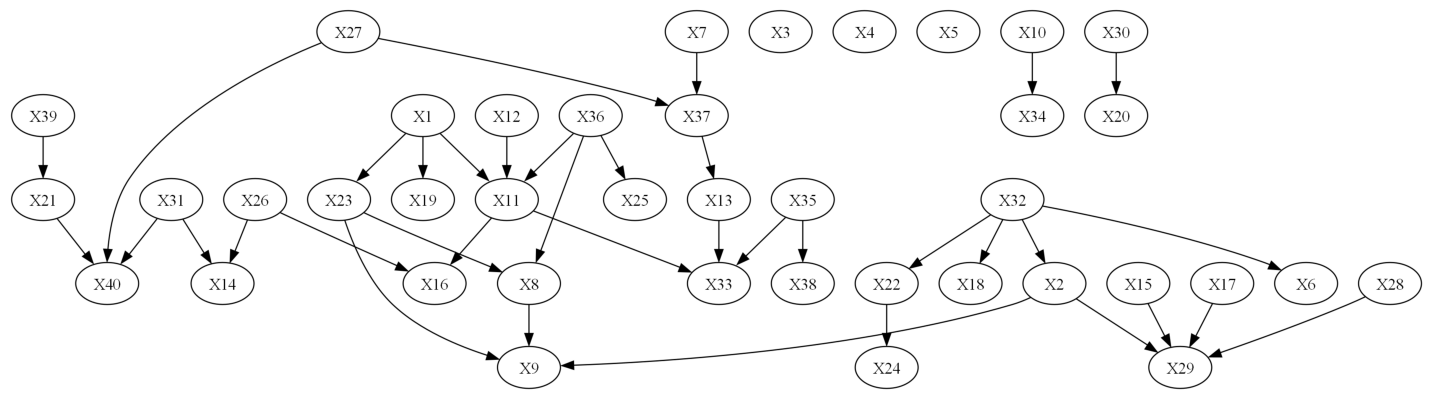

In [ ]:
cluster_dag.true_dag.draw_pydot_graph()

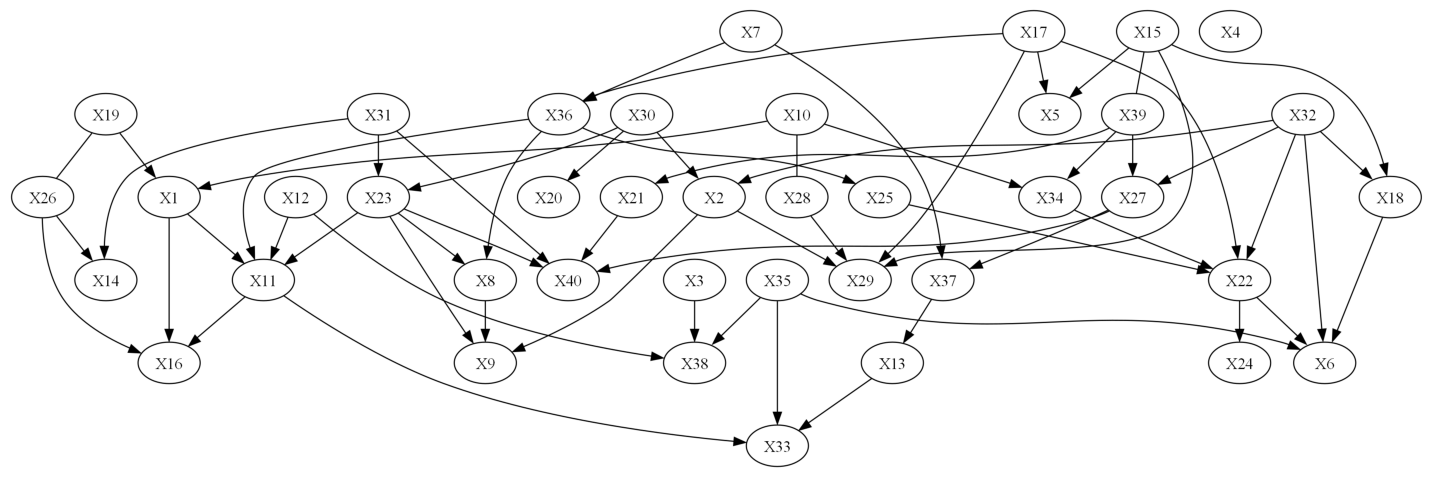

In [ ]:
est_graph_v1.draw_pydot_graph()

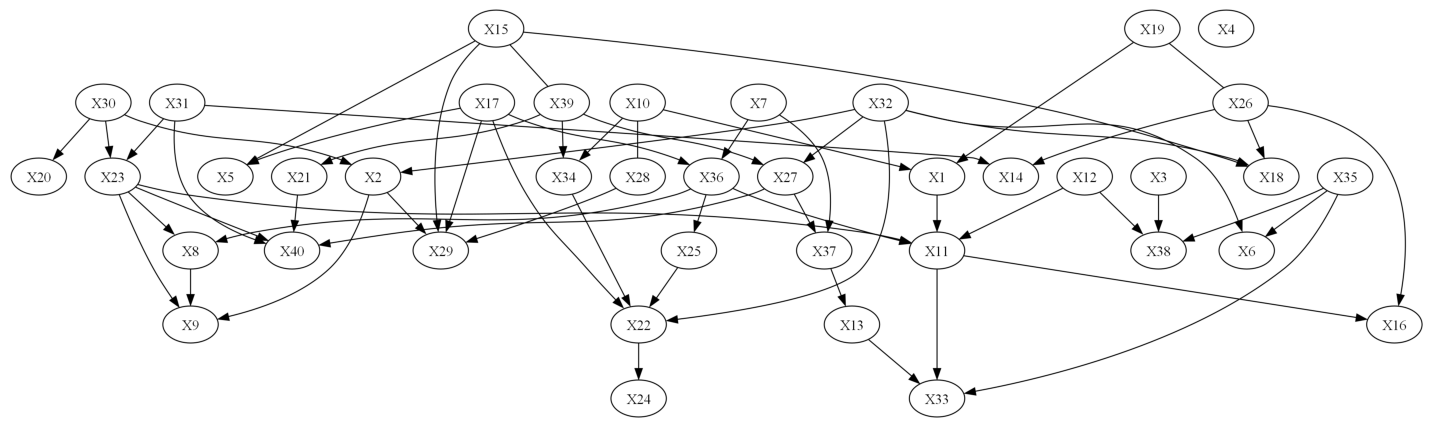

In [ ]:
est_graph_v2.draw_pydot_graph()

In [ ]:
evaluation_v1 = Evaluator(truth = cluster_dag.true_dag.G, est = est_graph_v1.G)
adjacency_confusion_v1, arrow_confusion_v1, shd_v1, sid_v1 = evaluation_v1.get_causallearn_metrics(sid = False)
print("Adjacency confusion: ", adjacency_confusion_v1)
print("Arrow confusion: ", arrow_confusion_v1)
print("SHD: ", shd_v1)
print("SID: ", sid_v1)

Adjacency confusion:  {'true_positive': 36, 'false_positive': 26, 'false_negative': 1, 'true_negative': 717, 'precision': 0.5806451612903226, 'recall': 0.972972972972973, 'f1_score': 0.7272727272727273}
Arrow confusion:  {'true_positive': 35.0, 'false_positive': 24.0, 'false_negative': 2.0, 'true_negative': 1539.0, 'precision': 0.5932203389830508, 'recall': 0.9459459459459459, 'f1_score': 0.7291666666666666, 'true_positive_ce': 35.0, 'false_positive_ce': 1.0, 'false_negative_ce': 1.0, 'true_negative_ce': 1563.0, 'precision_ce': 0.9722222222222222, 'recall_ce': 0.9722222222222222, 'f1_score_ce': 0.9722222222222222}
SHD:  28
SID:  {'sid_lower': None}


In [ ]:
evaluation_v2 = Evaluator(truth = cluster_dag.true_dag.G, est = est_graph_v2.G)
adjacency_confusion_v2, arrow_confusion_v2, shd_v2, sid_v2 = evaluation_v2.get_causallearn_metrics(sid = False)
print("Adjacency confusion: ", adjacency_confusion_v2)
print("Arrow confusion: ", arrow_confusion_v2)
print("SHD: ", shd_v2)
print("SID: ", sid_v2)

Adjacency confusion:  {'true_positive': 36, 'false_positive': 24, 'false_negative': 1, 'true_negative': 719, 'precision': 0.6, 'recall': 0.972972972972973, 'f1_score': 0.7422680412371134}
Arrow confusion:  {'true_positive': 35.0, 'false_positive': 22.0, 'false_negative': 2.0, 'true_negative': 1541.0, 'precision': 0.6140350877192983, 'recall': 0.9459459459459459, 'f1_score': 0.7446808510638299, 'true_positive_ce': 35.0, 'false_positive_ce': 1.0, 'false_negative_ce': 1.0, 'true_negative_ce': 1563.0, 'precision_ce': 0.9722222222222222, 'recall_ce': 0.9722222222222222, 'f1_score_ce': 0.9722222222222222}
SHD:  26
SID:  {'sid_lower': None}


In [ ]:
print(adjacency_confusion_v1 == adjacency_confusion_v2)
print(arrow_confusion_v1 == arrow_confusion_v2)
print(shd_v1 == shd_v2)
print(sid_v1 == sid_v2)

False
False
False
True


In [ ]:
# Comparison with baseline pc
from causallearn.search.ConstraintBased.PC import pc
# node_names = ['0', '1', '2', '3', '4', '5', '6', '7', '8', '9']
causallearn_cg = pc(cluster_dag.data, alpha = 0.1, verbose=False, node_names=node_names)

Depth=3, working on node 39: 100%|██████████| 40/40 [00:00<00:00, 760.14it/s] 


In [ ]:
evaluation_causallearn = Evaluator(truth = cluster_dag.true_dag.G, est = causallearn_cg.G)
cl_adjacency_confusion, cl_arrow_confusion, cl_shd, cl_sid  = evaluation_causallearn.get_causallearn_metrics(sid = False)
print("Adjacency confusion: ", cl_adjacency_confusion)
print("Arrow confusion: ", cl_arrow_confusion)
print("SHD: ", cl_shd)
# print("SID", cl_sid)

Adjacency confusion:  {'true_positive': 35, 'false_positive': 11, 'false_negative': 2, 'true_negative': 732, 'precision': 0.7608695652173914, 'recall': 0.9459459459459459, 'f1_score': 0.8433734939759038}
Arrow confusion:  {'true_positive': 23.0, 'false_positive': 17.0, 'false_negative': 14.0, 'true_negative': 1546.0, 'precision': 0.575, 'recall': 0.6216216216216216, 'f1_score': 0.5974025974025973, 'true_positive_ce': 23.0, 'false_positive_ce': 6.0, 'false_negative_ce': 12.0, 'true_negative_ce': 1559.0, 'precision_ce': 0.7931034482758621, 'recall_ce': 0.6571428571428571, 'f1_score_ce': 0.71875}
SHD:  19


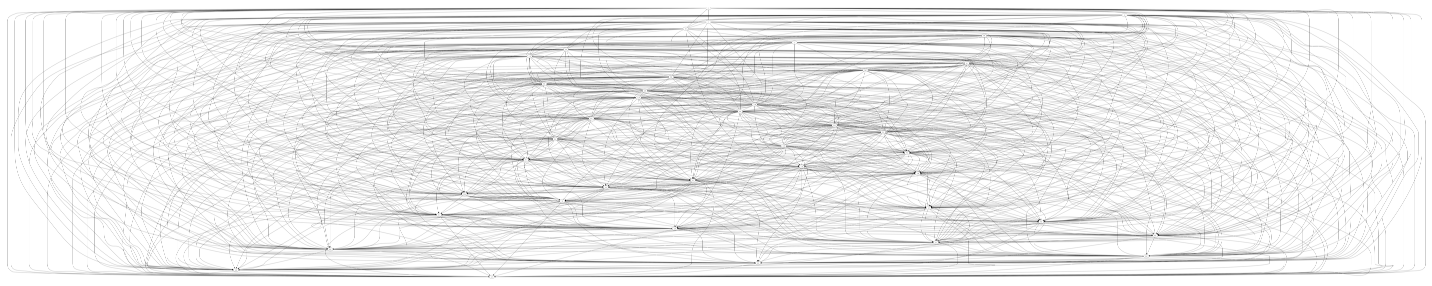

In [ ]:
cluster_dag.cdag_to_mpdag()
cluster_dag.draw_mpdag()

In [ ]:
pruned_causallearn_cg = Evaluator.get_cluster_pruned_benchmark(cluster_dag, cluster_dag.cg)
pruned_evaluation_causallearn = Evaluator(truth = cluster_dag.true_dag.G, est = pruned_causallearn_cg.G)
pruned_cl_adjacency_confusion, pruned_cl_arrow_confusion, pruned_cl_shd, pruned_cl_sid  = pruned_evaluation_causallearn.get_causallearn_metrics(sid = False)
print("Adjacency confusion: ", pruned_cl_adjacency_confusion)
print("Arrow confusion: ", pruned_cl_arrow_confusion)
print("SHD: ", pruned_cl_shd)

Adjacency confusion:  {'true_positive': 37, 'false_positive': 743, 'false_negative': 0, 'true_negative': 0, 'precision': 0.047435897435897434, 'recall': 1.0, 'f1_score': 0.0905752753977968}
Arrow confusion:  {'true_positive': 31.0, 'false_positive': 463.0, 'false_negative': 6.0, 'true_negative': 1100.0, 'precision': 0.06275303643724696, 'recall': 0.8378378378378378, 'f1_score': 0.1167608286252354, 'true_positive_ce': 31.0, 'false_positive_ce': 0.0, 'false_negative_ce': 6.0, 'true_negative_ce': 1563.0, 'precision_ce': 1.0, 'recall_ce': 0.8378378378378378, 'f1_score_ce': 0.911764705882353}
SHD:  743


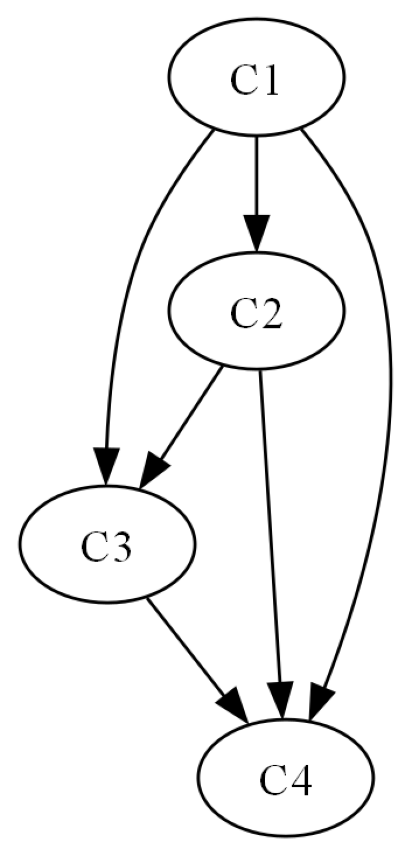

In [ ]:
cluster_dag.cluster_graph.draw_pydot_graph()

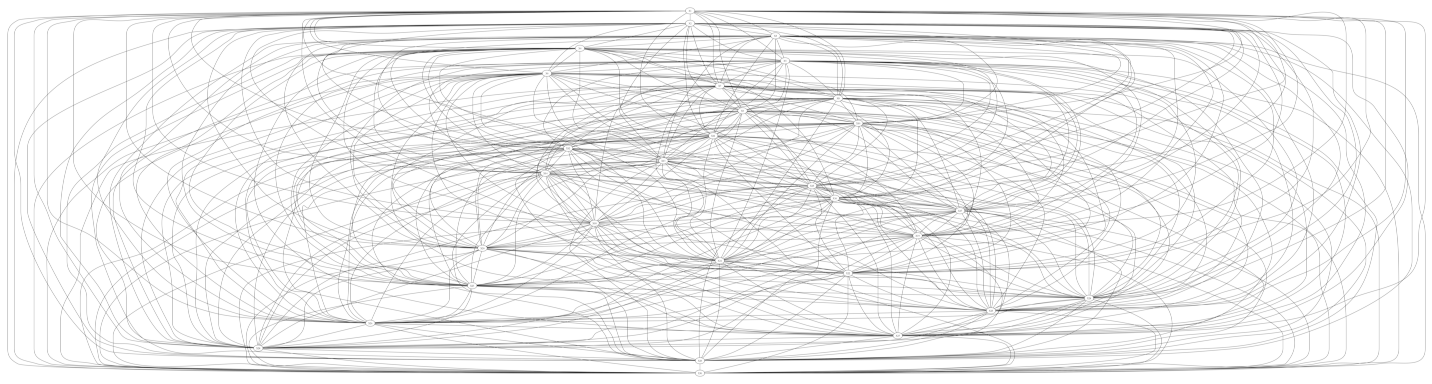

In [ ]:
from causallearn.graph.GraphClass import CausalGraph
cg_full = CausalGraph(no_of_var = 30)
cg_full.draw_pydot_graph()

In [ ]:
full_evaluation = Evaluator(truth = cluster_dag.true_dag.G, est = cg_full.G)
full_adjacency_confusion, full_arrow_confusion, full_shd, full_sid  = full_evaluation.get_causallearn_metrics(sid = False)
print("Adjacency confusion: ", full_adjacency_confusion)
print("Arrow confusion: ", full_arrow_confusion)
print("SHD: ", full_shd)

AssertionError: 

In [ ]:
# causallearn_cg_dsep = pc(cluster_dag.data, alpha = 0.01, indep_test = 'd_separation',  verbose=False, node_names=node_names, true_dag = cluster_dag.true_dag.nx_graph)

In [ ]:
evaluation_causallearn_dsep = Evaluator(truth = cluster_dag.true_dag.G, est = causallearn_cg_dsep.G)
cl_adjacency_confusion, cl_arrow_confusion, cl_shd, cl_sid = evaluation_causallearn_dsep.get_causallearn_metrics(sid = True)
print("Adjacency confusion: ", cl_adjacency_confusion)
print("Arrow confusion: ", cl_arrow_confusion)
print("SHD: ", cl_shd)
print("SID", cl_sid)

NameError: name 'causallearn_cg_dsep' is not defined

In [ ]:
print(adjacency_confusion == cl_adjacency_confusion)
print(arrow_confusion == cl_arrow_confusion)
print(shd == cl_shd)

True
False
True


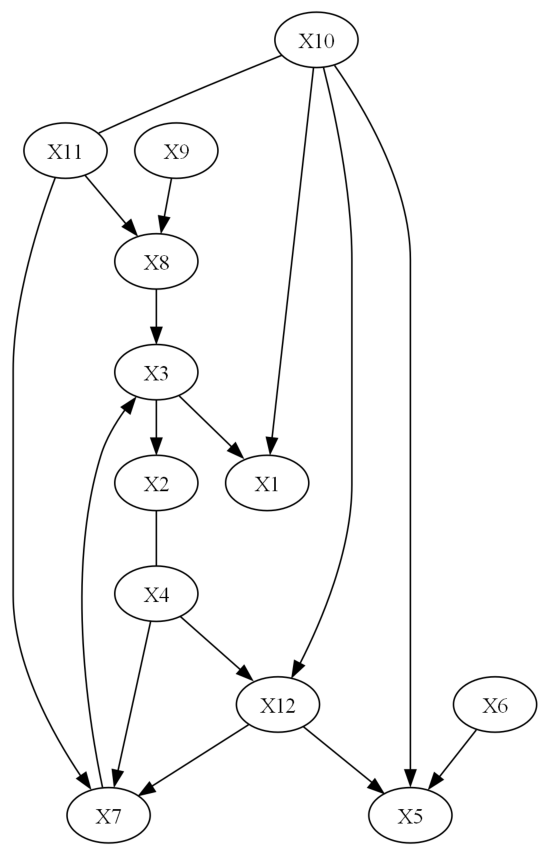

In [ ]:
causallearn_cg.draw_pydot_graph()

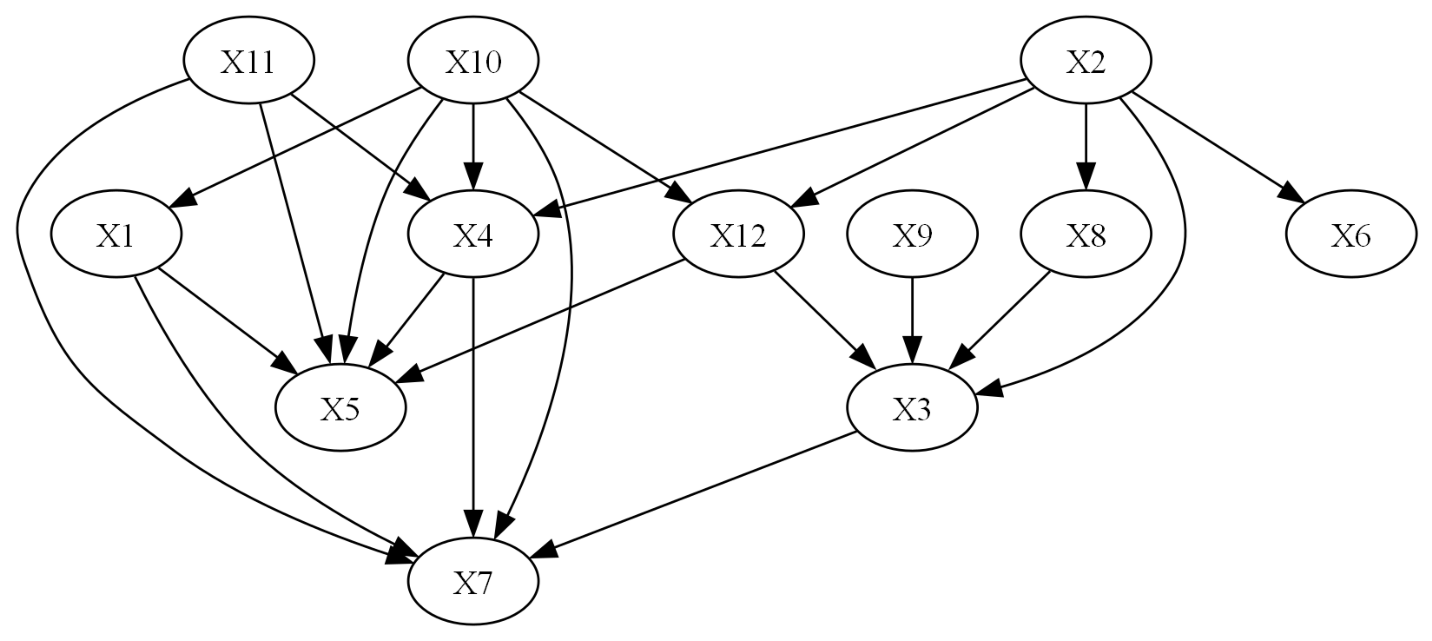

In [ ]:
cluster_dag.true_dag.draw_pydot_graph()

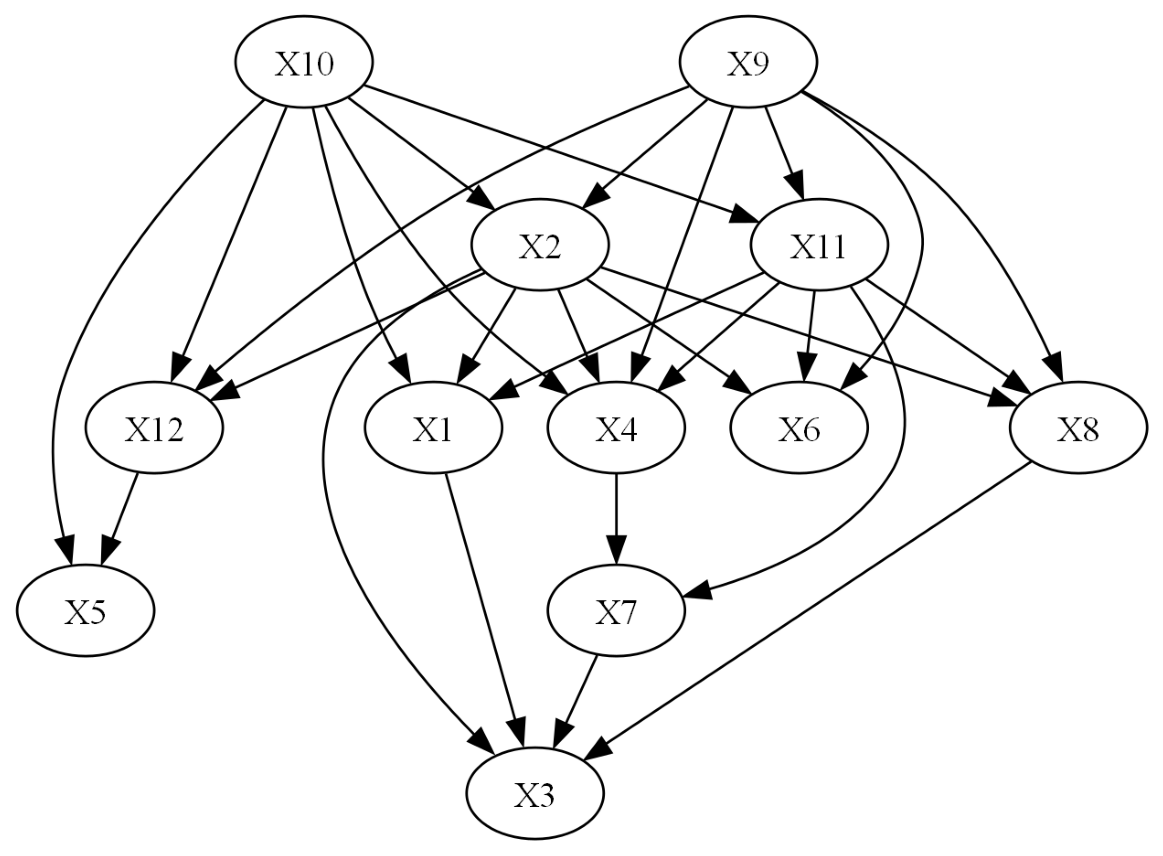

In [ ]:
est_graph.draw_pydot_graph()

{'C1': ['X10'], 'C2': ['X2', 'X9', 'X11', 'X1'], 'C3': ['X6'], 'C4': ['X8', 'X12'], 'C5': ['X4'], 'C6': ['X3', 'X5', 'X7']}


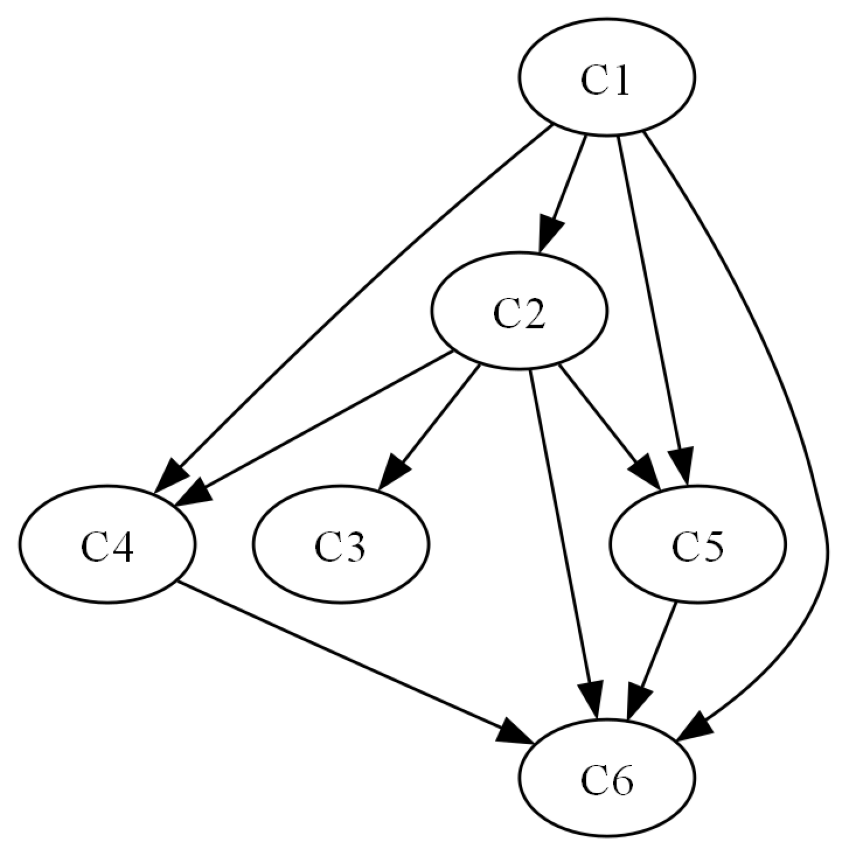

In [ ]:
print(cluster_dag.cluster_mapping)
cluster_dag.cluster_graph.draw_pydot_graph()

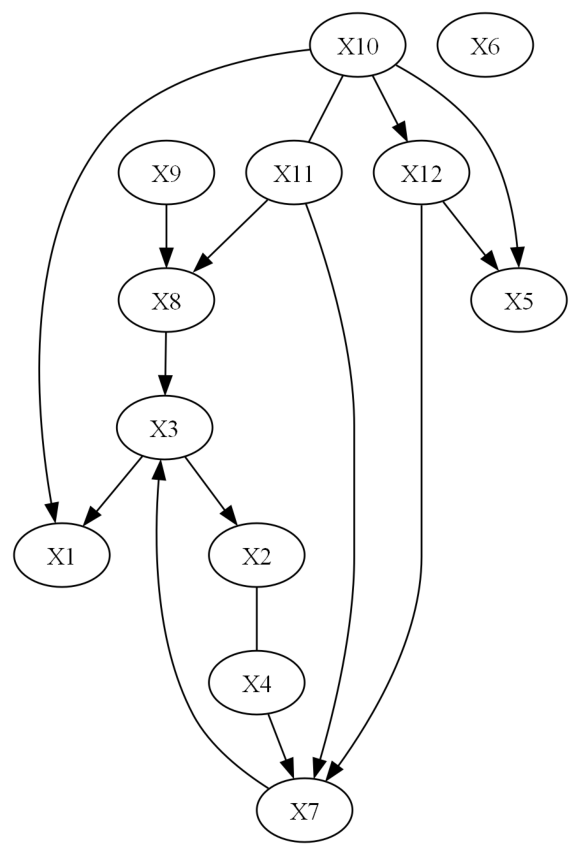

In [ ]:
causallearn_cg.draw_pydot_graph()

In [ ]:
from causallearn.graph.Edge import Edge
from causallearn.graph.Endpoint import Endpoint
n_6 = ClusterDAG.get_node_by_name('X6', cluster_dag.true_dag)
n_8 = ClusterDAG.get_node_by_name('X8', cluster_dag.true_dag)
edge = Edge(n_6, n_8, Endpoint.TAIL, Endpoint.ARROW)
test_cg = causallearn_cg
test_cg.G.add_edge(edge)

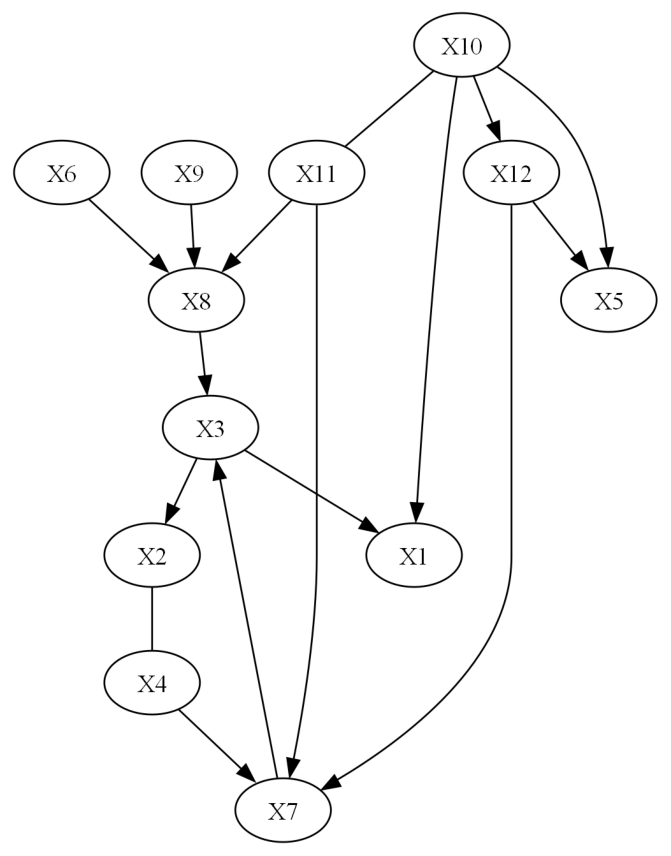

In [ ]:
test_cg.draw_pydot_graph()

In [ ]:
from clustercausal.clusterdag.ClusterDAG import ClusterDAG
from causallearn.graph.Edge import Edge
from causallearn.graph.Endpoint import Endpoint

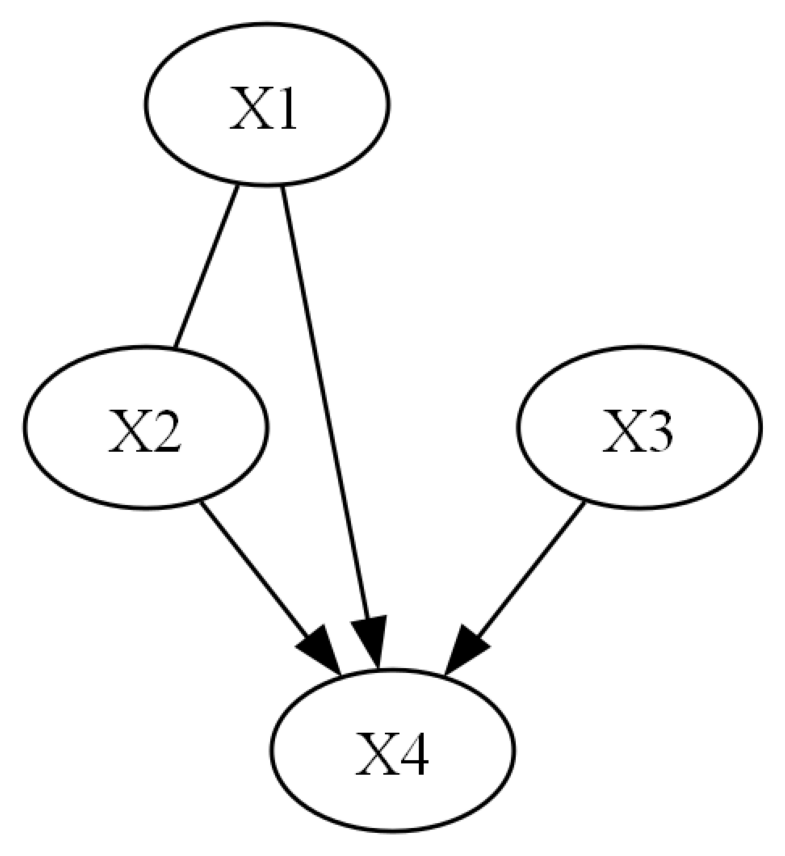

In [ ]:
cluster_mapping = {'C1' : ['X1', 'X2'], 'C2' : ['X3'], 'C3' : ['X4']}
cluster_edges = [('C1', 'C3'), ('C2', 'C3')]
cdag = ClusterDAG(cluster_mapping = cluster_mapping, cluster_edges = cluster_edges)
cdag.cdag_to_mpdag()
cdag.cg.draw_pydot_graph()

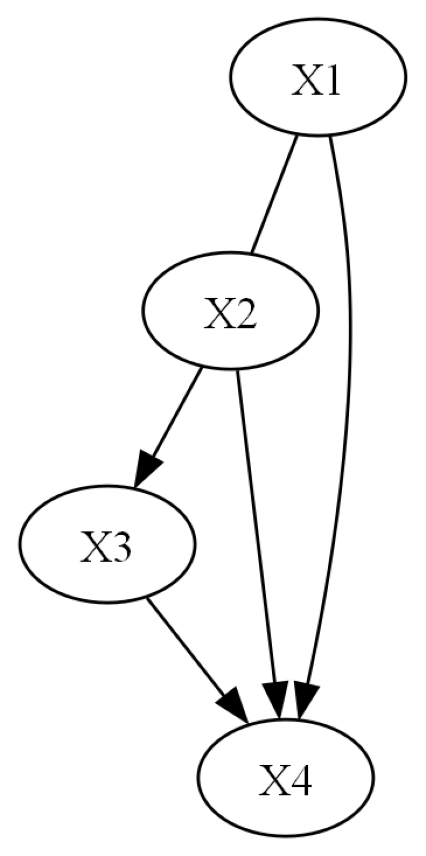

In [ ]:
n_2 = ClusterDAG.get_node_by_name('X2', cdag.cg)
n_3 = ClusterDAG.get_node_by_name('X3', cdag.cg)
edge = Edge(n_2, n_3, Endpoint.TAIL, Endpoint.ARROW)
wrong_cg = cdag.cg
wrong_cg.G.add_edge(edge)
wrong_cg.draw_pydot_graph()

In [ ]:
%load_ext autoreload
%autoreload 2
from clustercausal.experiments.Evaluator import Evaluator
pruned_cg = Evaluator.get_cluster_pruned_benchmark(cdag = cdag, cg = wrong_cg)
pruned_cg == cdag.cg

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


True

In [ ]:
# n_1 = ClusterDAG.get_node_by_name('X1', cdag.cg)
# n_2 = ClusterDAG.get_node_by_name('X2', cdag.cg)
# edge = Edge(n_1, n_2, Endpoint.TAIL, Endpoint.TAIL)
# cdag.cg.G.remove_edge(edge)
# cdag.cg.draw_pydot_graph()

In [ ]:
test_cg = evaluation.get_cluster_pruned_benchmark(cdag = cdag, cg = cdag.cg)
test_cg.draw_pydot_graph()